# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [273]:
import json
import pandas as pd

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 14:04 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 14:05 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 14:05 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 14:05 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 14:05 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 14:05 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 14:05 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 14:05 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 14:05 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [254]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
%%time
ratings.take(5)

CPU times: user 10.4 ms, sys: 3.42 ms, total: 13.8 ms
Wall time: 3.67 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [14]:
ratings.count()

25000095

Количество пользователей

In [15]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 20.9 ms, sys: 10.7 ms, total: 31.6 ms
Wall time: 1min 22s


162541

Сохраним датасет в память

In [16]:
ratings = ratings.persist()

In [18]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job 4 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:806)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:804)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:804)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:1581)
	at org.apache.spark.SparkContext$$anonfun$stop$9.apply$mcV$sp(SparkContext.scala:1751)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1230)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1750)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend$MonitorThread.run(YarnClientSchedulerBackend.scala:147)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1843)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1940)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


Количество фильмов

In [12]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 31.8 ms, sys: 14.7 ms, total: 46.4 ms
Wall time: 55.6 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [10]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [15]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [23]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (175077, (5.0, ['175077', 'Fatal Call (2012)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [24]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [25]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-02 17:18 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58976 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112528 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131435 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114337 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133615 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117755 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     142933 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132298 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167627 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [26]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [27]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [28]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

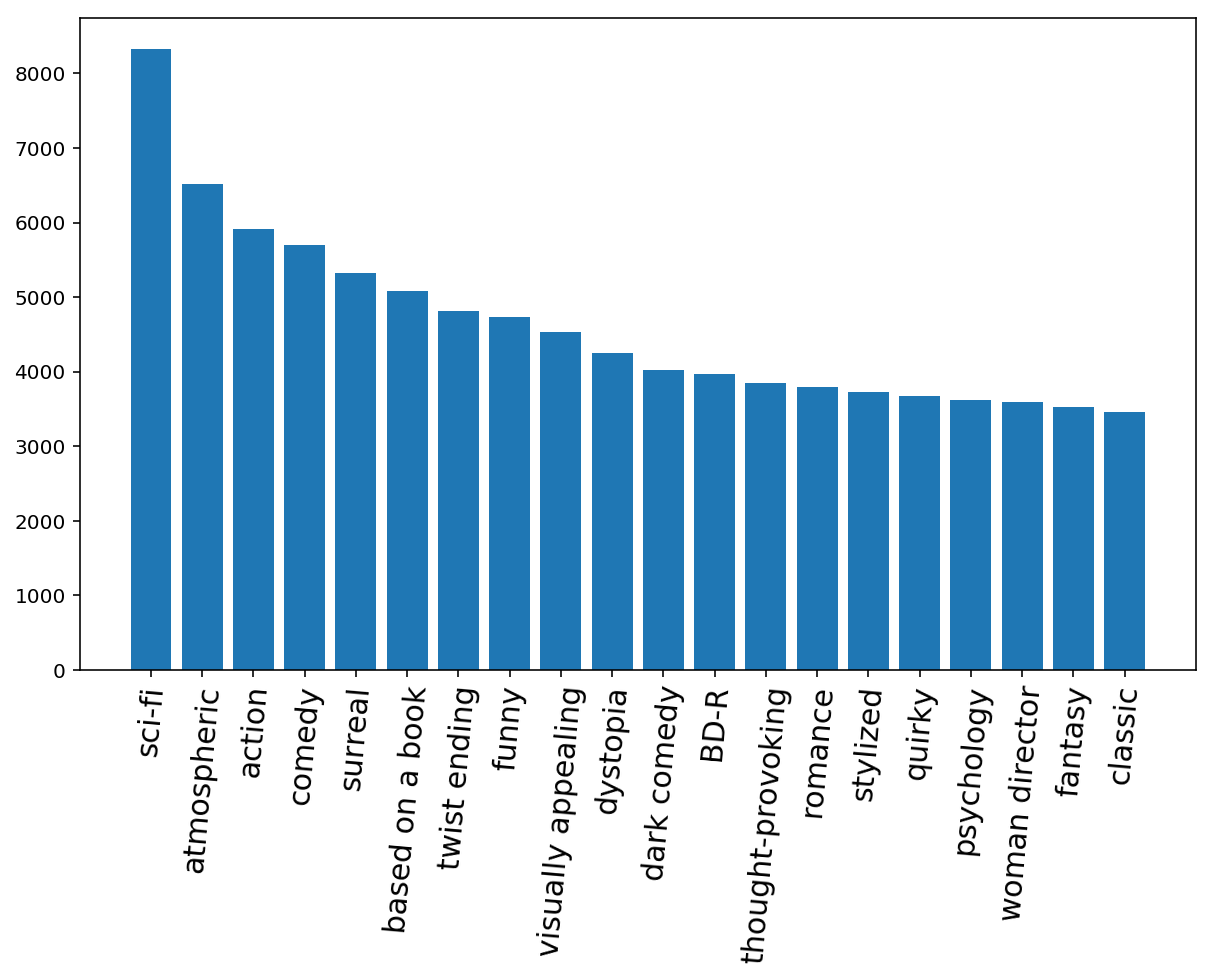

In [29]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [11]:
######################################
######### YOUR CODE HERE #############
######################################
rating_counts = ratings \
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)


In [21]:
titles_and_counts = rating_counts\
    .join(movies)\
    .sortBy(lambda item: item[1][0], ascending=False)\
    .map(lambda item: (item[1][1][1], item[1][0]))
titles_and_counts.take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [35]:
######################################
######### YOUR CODE HERE #############
######################################
only_fives = ratings \
    .map(lambda r: (r.movie_id, r.rating))\
    .filter(lambda r: r[1] == 5.0)\
    .map(lambda r: (r[0], 1))\
    .reduceByKey(lambda a, b: a + b)

titles_and_five_counts = only_fives\
    .join(movies)\
    .sortBy(lambda item: item[1][0], ascending=False)\
    .map(lambda item: (item[1][1][1], item[1][0]))
titles_and_five_counts.take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [81]:
######################################
######### YOUR CODE HERE #############
######################################
average_dist = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1)))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda item: round(item[0] / item[1], 1))\
    .map(lambda item: (item[1], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

<BarContainer object of 45 artists>

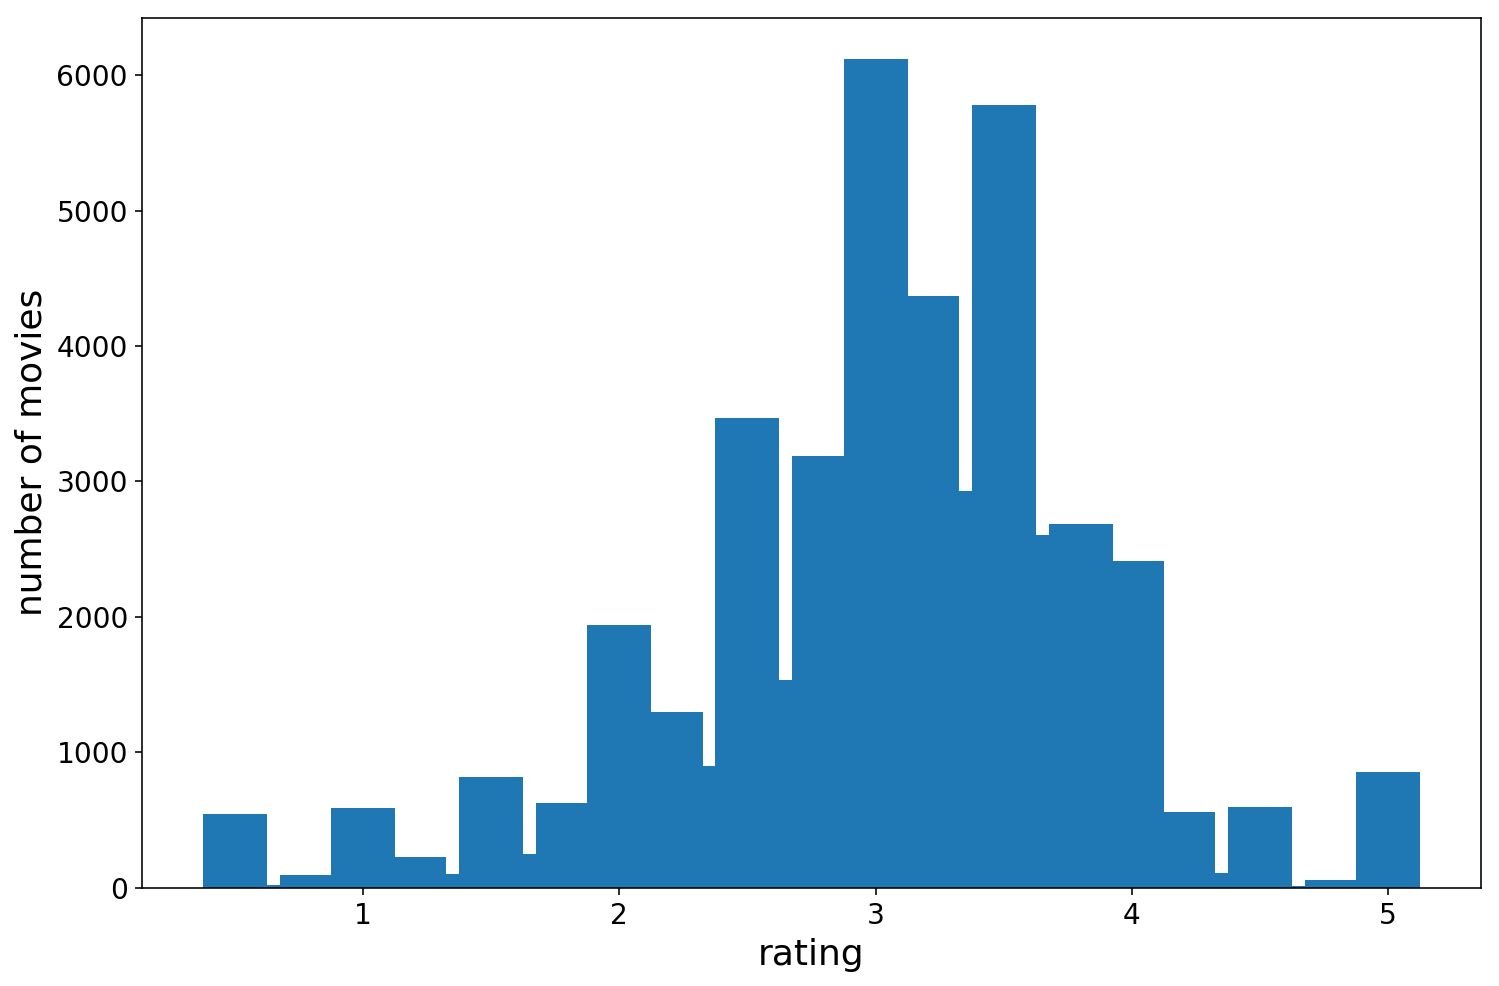

In [89]:
x, y = tuple(zip(*sorted(
        average_dist,
        key=lambda item: item[0]
    )
))

plt.subplots(figsize=(12, 8))
plt.xlabel('rating', fontsize=18)
plt.ylabel('number of movies', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.bar(x, y, width=0.25)

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [111]:
######################################
######### YOUR CODE HERE #############
######################################
rating_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()
#     .map(lambda item: (item[1], 1)) \
#     .reduceByKey(lambda a, b: a + b) \
    

Метод plt.bar здесь рисовал график плохо, поэтому пришлось воспользоваться методом plt.hist, чтоб группировать по количеству оценок

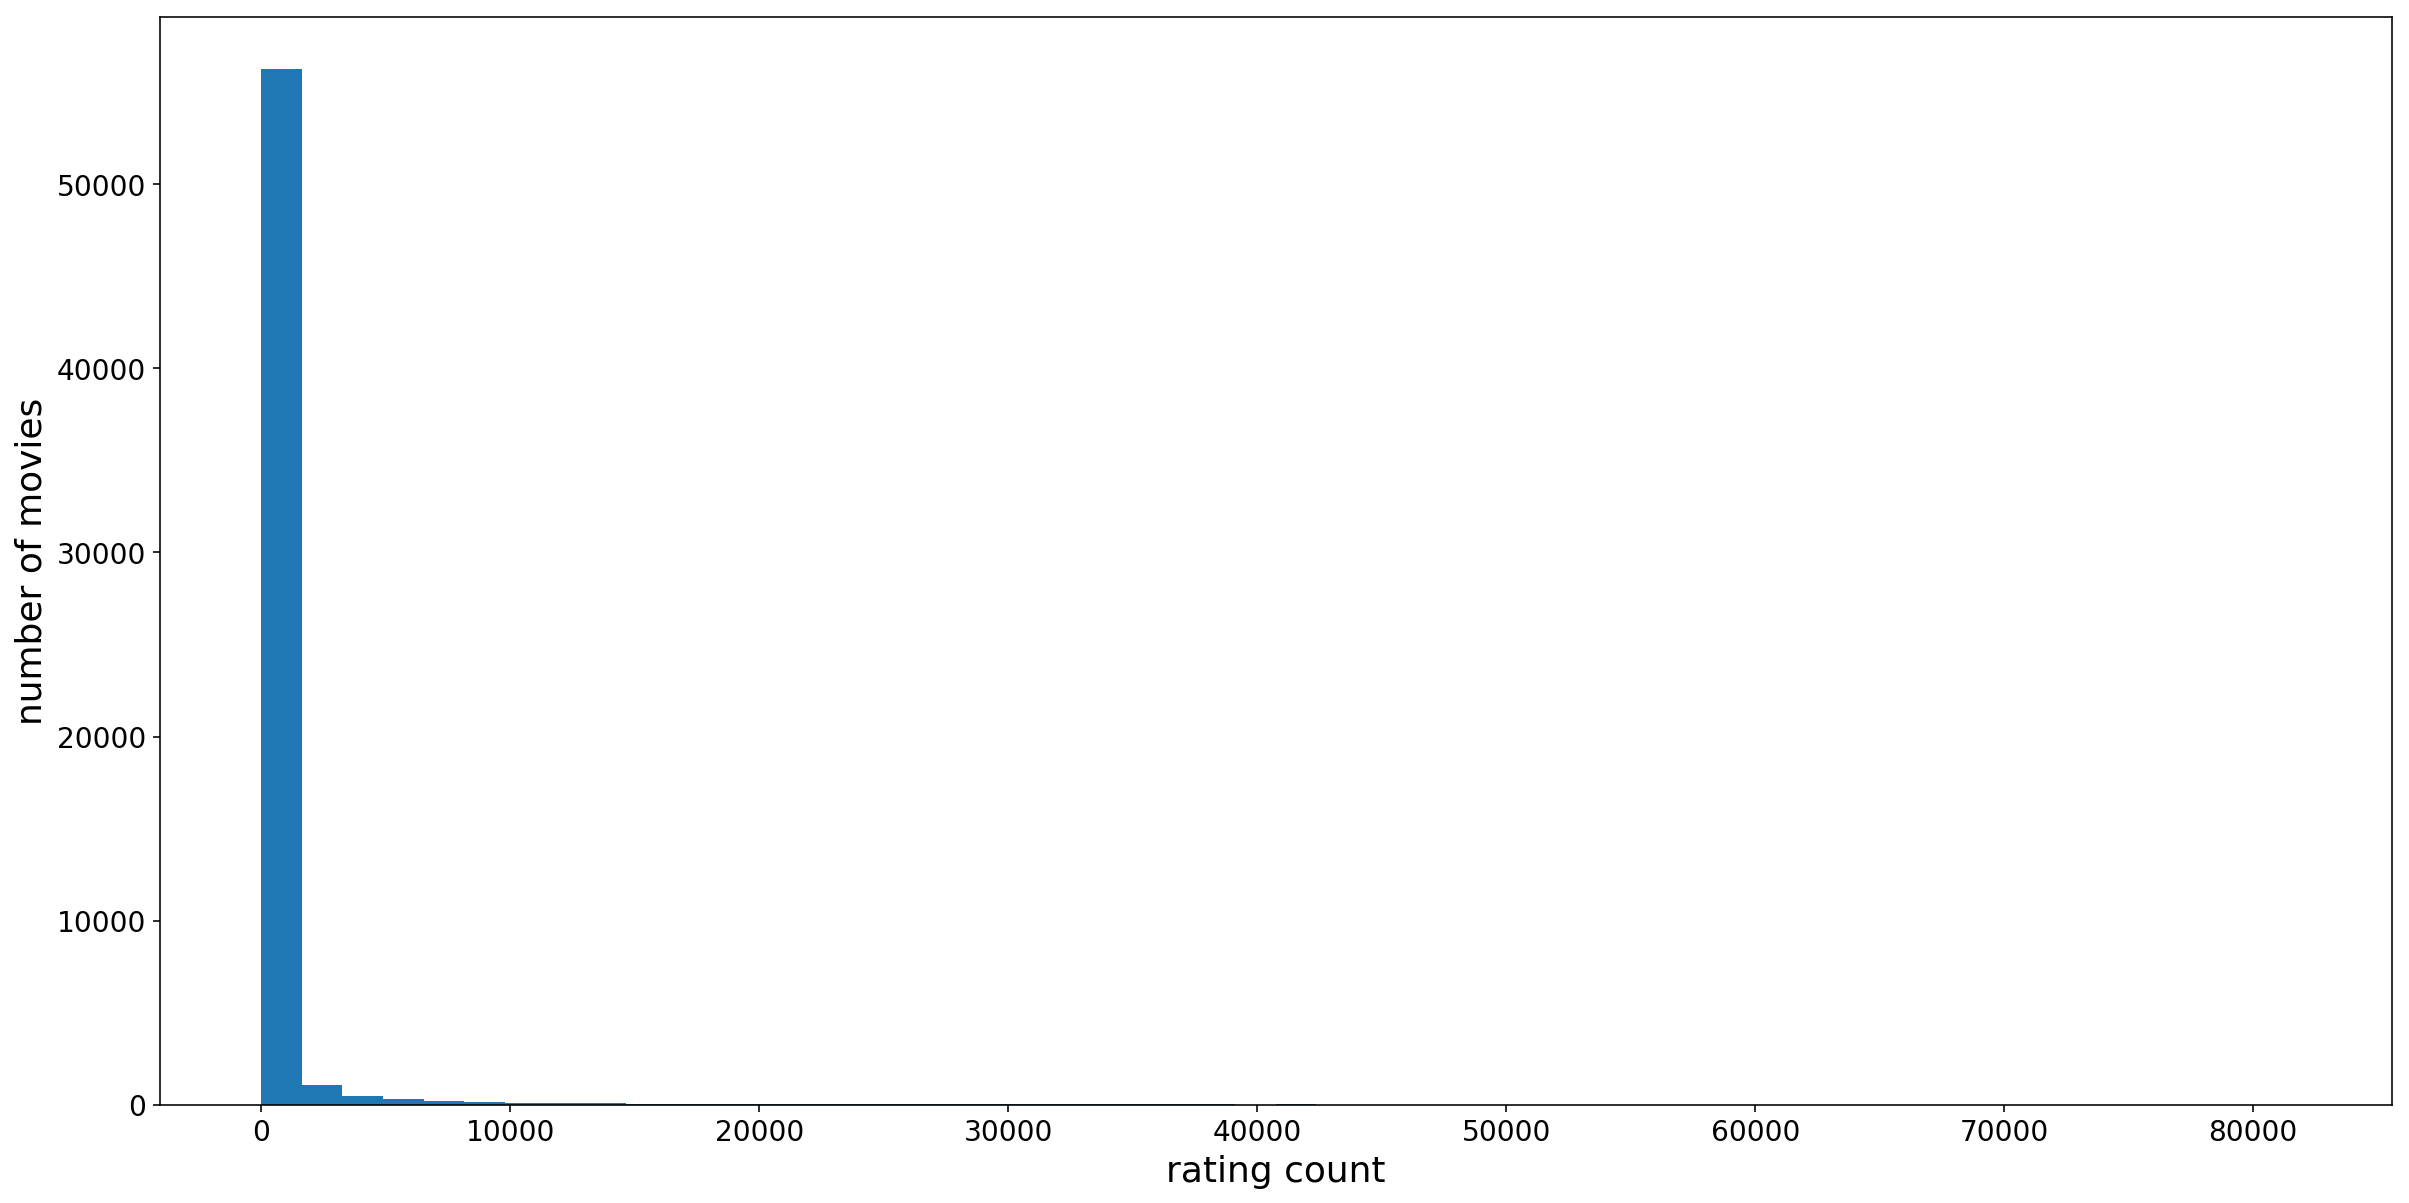

In [128]:
x, y = tuple(zip(*sorted(
        rating_count,
        key=lambda item: item[0]
    )
))

plt.subplots(figsize=(20, 10))
plt.xlabel('rating count', fontsize=18)
plt.ylabel('number of movies', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(y, bins=50)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [175]:
######################################
######### YOUR CODE HERE #############
######################################
movies = sc.textFile(MOVIES_PATH)
genre_count = movies \
    .filter(lambda item: 'genres' not in item) \
    .map(lambda item: item.split(',')[-1]) \
    .flatMap(lambda item: item.split('|')) \
    .map(lambda item: (item, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

<BarContainer object of 19 artists>

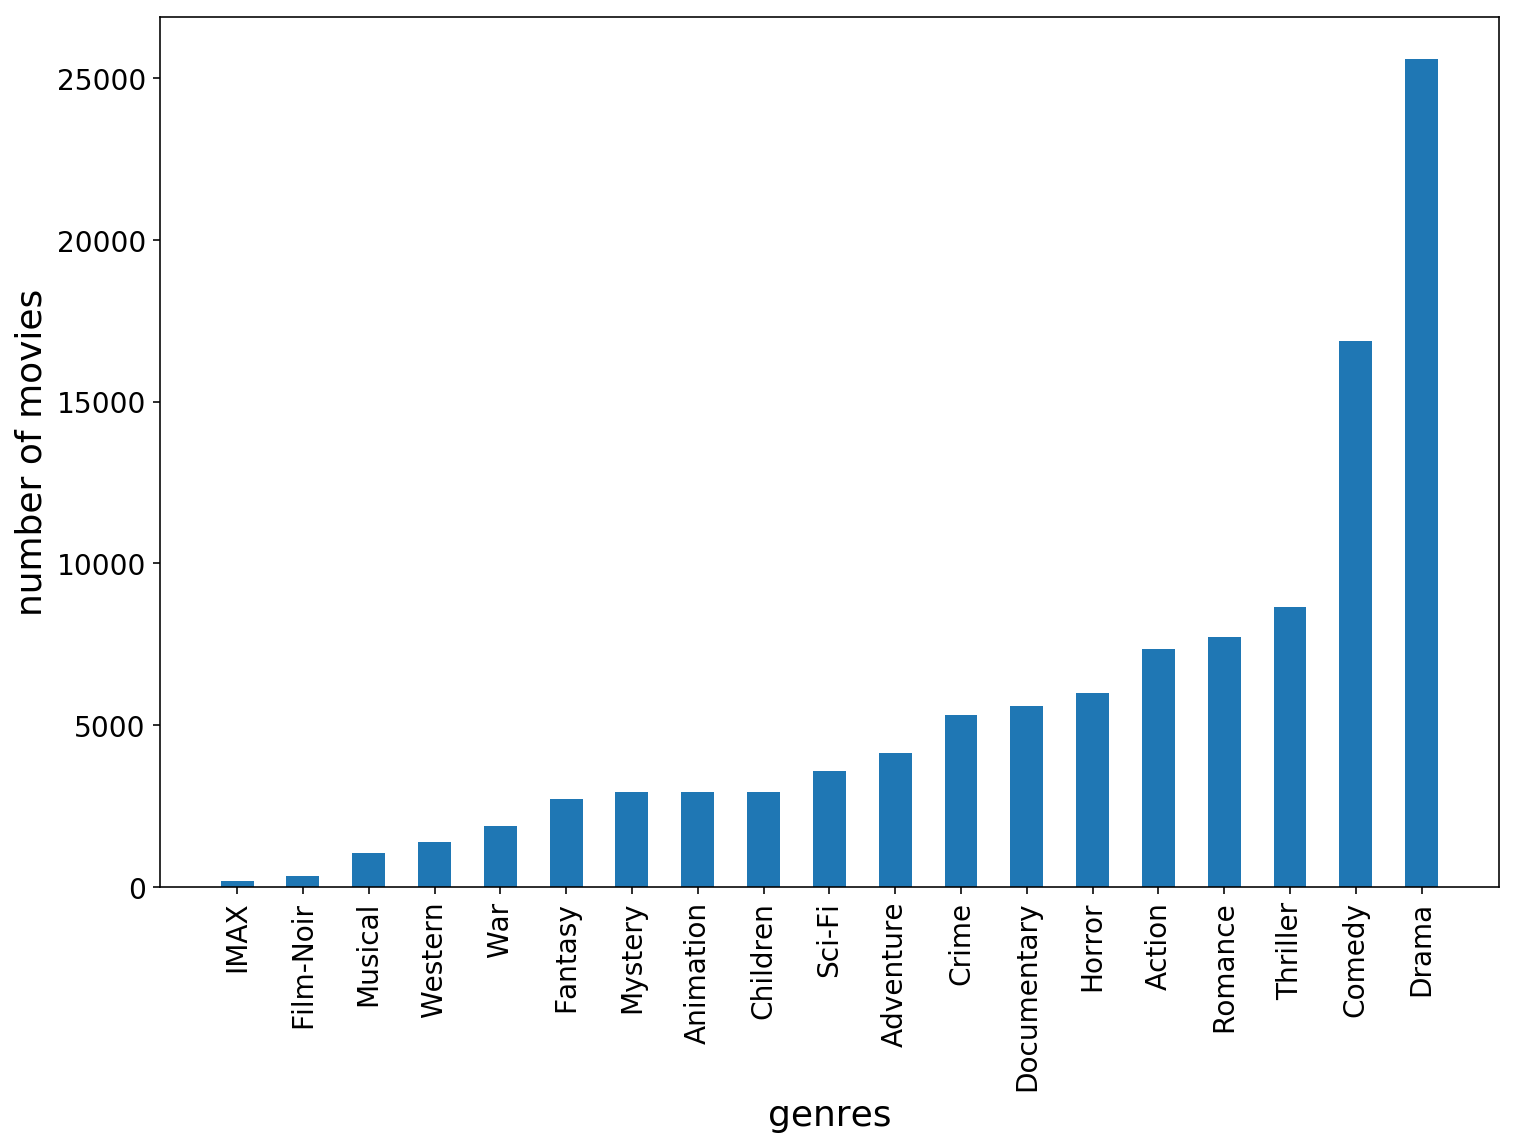

In [184]:
x, y = list(zip(
    *sorted(genre_count, key=lambda item: item[1])
))

plt.subplots(figsize=(12, 8))
plt.xlabel('genres', fontsize=18)
plt.ylabel('number of movies', fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.bar(x, y, width=0.5)

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [199]:
links = sc.textFile(LINKS_PATH)
tmdb = sc.textFile(TMDB_PATH)

### фильмы с Томом Хэнксом

In [243]:
######################################
######### YOUR CODE HERE #############
######################################
actors = tmdb \
    .map(lambda item: json.loads(item))\
    .filter(lambda item: 'id' in item) \
    .map(lambda item: (item['id'], item['casts']['cast'])) \
    .map(lambda item: (item[0], [(x['id'], x['name']) for x in item[1]])) \
    .flatMap(lambda item: [(item[0], x) for x in item[1]])
actors.take(10)

[(862, (31, 'Tom Hanks')),
 (862, (12898, 'Tim Allen')),
 (862, (7167, 'Don Rickles')),
 (862, (12899, 'Jim Varney')),
 (862, (12900, 'Wallace Shawn')),
 (862, (7907, 'John Ratzenberger')),
 (862, (8873, 'Annie Potts')),
 (862, (1116442, 'John Morris')),
 (862, (12901, 'Erik von Detten')),
 (862, (12133, 'Laurie Metcalf'))]

In [248]:
tom_hanks_movies_id = actors \
    .filter(lambda item: item[1][0] == 31)
tom_hanks_movies_id.take(10)

[(862, (31, 'Tom Hanks')),
 (568, (31, 'Tom Hanks')),
 (13, (31, 'Tom Hanks')),
 (9800, (31, 'Tom Hanks')),
 (858, (31, 'Tom Hanks')),
 (32562, (31, 'Tom Hanks')),
 (9591, (31, 'Tom Hanks')),
 (857, (31, 'Tom Hanks')),
 (11974, (31, 'Tom Hanks')),
 (2619, (31, 'Tom Hanks'))]

In [232]:
links_table = links \
    .map(lambda item: item.split(',')) \
    .filter(lambda item: item[-1].isdigit() and item[0].isdigit()) \
    .map(lambda item: (int(item[-1]), int(item[0])))
links_table.take(10)

[(862, 1),
 (8844, 2),
 (15602, 3),
 (31357, 4),
 (11862, 5),
 (949, 6),
 (11860, 7),
 (45325, 8),
 (9091, 9),
 (710, 10)]

In [257]:
movies.take(10)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)']),
 (6, ['6', 'Heat (1995)']),
 (7, ['7', 'Sabrina (1995)']),
 (8, ['8', 'Tom and Huck (1995)']),
 (9, ['9', 'Sudden Death (1995)']),
 (10, ['10', 'GoldenEye (1995)'])]

In [274]:
tom_hanks_movies = links_table \
    .join(tom_hanks_movies_id) \
    .map(lambda item: item[1]) \
    .join(movies) \
    .map(lambda item: item[1][1][1]) \
    .collect()

In [277]:
pd.DataFrame(tom_hanks_movies, columns = ['Titles'], index=range(1, len(tom_hanks_movies)+1))

,Titles
1,Sleepless in Seattle (1993)
2,"""Celluloid Closet"
3,Elvis Has Left the Building (2004)
4,"""'burbs"
5,Splash (1984)
6,Every Time We Say Goodbye (1986)
7,"""League of Their Own"
8,Captain Phillips (2013)
9,Toy Story of Terror (2013)
10,Shooting War (2000)


### 10 актеров с наибольшим кол-вом фильмов

In [286]:
all_actors_movies = links_table \
    .join(actors) \
    .map(lambda item: item[1]) \
    .join(movies) \
    .map(lambda item: (item[1][0][1], 1)) \
    .reduceByKey(lambda a, b: a + b)
#     .sortBy(lambda item: item[1], ascending=False)
all_actors_movies.take(10)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: java.lang.IllegalStateException: SparkContext has been shutdown
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1835)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor40.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################